# Part 04: Model Selection & Training
Choosing the right model, train, and evaluate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

## Load the dataset

In [2]:
# loading the dataset
data = pd.read_csv('credit_risk_dataset.csv')
print(data.shape)
data.head()

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Standard Cleaning

- remove odd data (e.g., age > 120 years, employment history length > age + 15 years)
- drop duplicates
- replace ordinal categorical variables or binary nominal variables with discrete numerical variables

In [3]:
# drop outlier and unreasonable data
data = data[(data['person_emp_length'].isnull()) | (data['person_age'] >= 15+data['person_emp_length'])]
data = data[data['person_age']<100]

# drop duplicates
data = data.drop_duplicates()

# replace strings with integers
data['cb_person_default_on_file'].replace(['Y', 'N'], [1, 0], inplace = True)
data['loan_grade'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G'], [1, 2, 3, 4, 5, 6, 7], inplace = True)

## Handle Missing Values

In [4]:
# HANDLE MISSING VALUES (Notebook 01)
# PART 1: person_emp_length
# replace the missing values in the original dataset with the median
data['person_emp_length'].fillna(data['person_emp_length'].median(), inplace = True)

# PART 2: loan_int_rate
# drop NA values to facilitate computations
data_noNA = data.dropna()

X = data_noNA[['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_grade', 'cb_person_default_on_file', 'loan_percent_income']]
X.loc[:, 'person_income'] = np.log(X['person_income'])
X.loc[:, 'loan_amnt'] = np.log(X['loan_amnt'])
y = data_noNA['loan_int_rate']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 34)

# train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# predict the test set results
y_pred = regressor.predict(X_test)

data_NA = data[data['loan_int_rate'].isnull()]
data_NA_X = data_NA[['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_grade', 'cb_person_default_on_file', 'loan_percent_income', 'loan_int_rate']]
data_NA_X.loc[:, 'person_income'] = np.log(data_NA_X['person_income'])
data_NA_X.loc[:, 'loan_amnt'] = np.log(data_NA_X['loan_amnt'])

data_NA_X.loc[:, 'loan_int_rate'] = regressor.predict(data_NA_X[['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_grade', 'cb_person_default_on_file', 'loan_percent_income']])

data.update(data_NA_X)

## Categorical Embeddings
Create indicator variables for the nominal categorical features `person_home_ownership` and `loan_intent`.

In [5]:
# categorical variable embeddings
# indicator variables
data = pd.get_dummies(data, columns = ['person_home_ownership', 'loan_intent'], drop_first = True)
data.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
1,21,9600.0,5.0,2,1000.0,11.14,0,0.10,0,2,False,True,False,True,False,False,False,False
2,25,9600.0,1.0,3,5500.0,12.87,1,0.57,0,3,False,False,False,False,False,True,False,False
3,23,65500.0,4.0,3,35000.0,15.23,1,0.53,0,2,False,False,True,False,False,True,False,False
4,24,54400.0,8.0,3,35000.0,14.27,1,0.55,1,4,False,False,True,False,False,True,False,False
5,21,9900.0,2.0,1,2500.0,7.14,1,0.25,0,2,False,True,False,False,False,False,False,True


## Class Imbalance 
### Remedy I
Class weights for logistic regression.

In [19]:
# compute the class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = {0: weights[0], 1: weights[1]}
# class_weights[0] = 0.01
# class_weights[1] = 0.99
print(class_weights)

{0: 0.6399628766636388, 1: 2.2861879232505644}


## Model: Logistic Regression
At first, we will try a logistic regression model with all the available features. This approach might be a bit naive. After all a lot of features might be correlated, and multicollinearity is something we have to avoid. We will simply explore this naive case, then we will check the covariance matrix of the different features and might make a more careful selection.

In [7]:
# split the data into training and testing sets
X = data.drop(columns = ['loan_status'])
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 34)

In [20]:
# logistic regression
logreg = LogisticRegression(class_weight = class_weights)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/Users/giorgoskementzidis/rgan_pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.7078062326442456
Precision:  0.39936229573535276
Recall:  0.7213822894168467
F1 Score:  0.5141097998973834


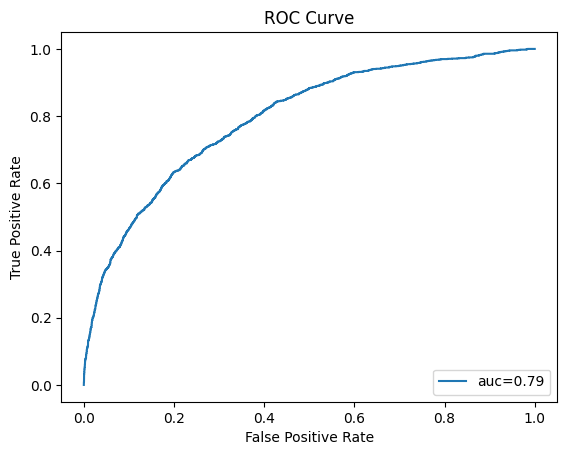

In [21]:
# evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))
print('F1 Score: ', metrics.f1_score(y_test, y_pred))

# ROC AUC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = 'auc='+str(auc.round(2)))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 4)
plt.show()

### Remedy II
Oversampling & Undersampling

In [22]:
# make a copy of the data frame
data_copy = data.copy()

# oversample the minority class and undersample the majority class
positiveSample = data_copy[data_copy['loan_status']==1].sample(n=10000, replace=True, random_state=1)
negativeSample = data_copy[data_copy['loan_status']==0].sample(n=10000, replace=False, random_state=1)
data_balanced = pd.concat([positiveSample, negativeSample]).sample(frac=1, random_state=12)
data_balanced['loan_status'].value_counts()

# split the data into training and testing sets
X = data_balanced.drop(columns = ['loan_status'])
y = data_balanced['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 34)

In [23]:
# logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

Accuracy:  0.702
Precision:  0.6886255924170616
Recall:  0.7308853118712274
F1 Score:  0.7091264031234749


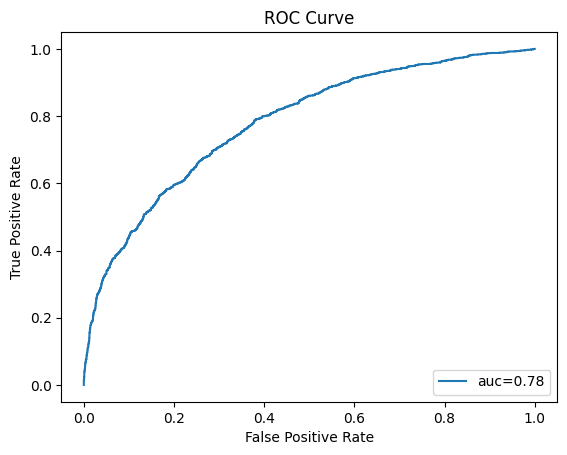

In [24]:
# evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))
print('F1 Score: ', metrics.f1_score(y_test, y_pred))

# ROC AUC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = 'auc='+str(auc.round(2)))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 4)
plt.show()

Overall, the oversampling & undersampling technique led to better results than the class weights adjustment. It seems like adjusting the class weights pushes recall up by sacrificing a bit of accuracy and precision. **RIGHT?**

In [25]:
# print the features and their coefficients
features = X.columns
coefficients = logreg.coef_[0]
feature_coefficients = pd.DataFrame({'feature': features, 'coefficient': coefficients})
print(feature_coefficients)

                        feature  coefficient
0                    person_age    -0.088223
1                 person_income    -0.000026
2             person_emp_length    -0.050079
3                    loan_grade     0.127153
4                     loan_amnt     0.000096
5                 loan_int_rate     0.186864
6           loan_percent_income     0.006790
7     cb_person_default_on_file     0.022461
8    cb_person_cred_hist_length     0.114412
9   person_home_ownership_OTHER    -0.000141
10    person_home_ownership_OWN    -0.022803
11   person_home_ownership_RENT     0.040299
12        loan_intent_EDUCATION    -0.020636
13  loan_intent_HOMEIMPROVEMENT     0.011066
14          loan_intent_MEDICAL     0.008139
15         loan_intent_PERSONAL    -0.006265
16          loan_intent_VENTURE    -0.025219


In [34]:
# check how each one of these features is correlated with the target variable
for feature in features:
    correlation = data_balanced[feature].corr(data_balanced['loan_status'])
    print('Feature:', feature, 'Correlation:', round(correlation,2))

Feature: person_age Correlation: -0.02
Feature: person_income Correlation: -0.19
Feature: person_emp_length Correlation: -0.1
Feature: loan_grade Correlation: 0.39
Feature: loan_amnt Correlation: 0.1
Feature: loan_int_rate Correlation: 0.37
Feature: loan_percent_income Correlation: 0.4
Feature: cb_person_default_on_file Correlation: 0.19
Feature: cb_person_cred_hist_length Correlation: -0.02
Feature: person_home_ownership_OTHER Correlation: 0.01
Feature: person_home_ownership_OWN Correlation: -0.15
Feature: person_home_ownership_RENT Correlation: 0.28
Feature: loan_intent_EDUCATION Correlation: -0.07
Feature: loan_intent_HOMEIMPROVEMENT Correlation: 0.04
Feature: loan_intent_MEDICAL Correlation: 0.06
Feature: loan_intent_PERSONAL Correlation: -0.02
Feature: loan_intent_VENTURE Correlation: -0.1


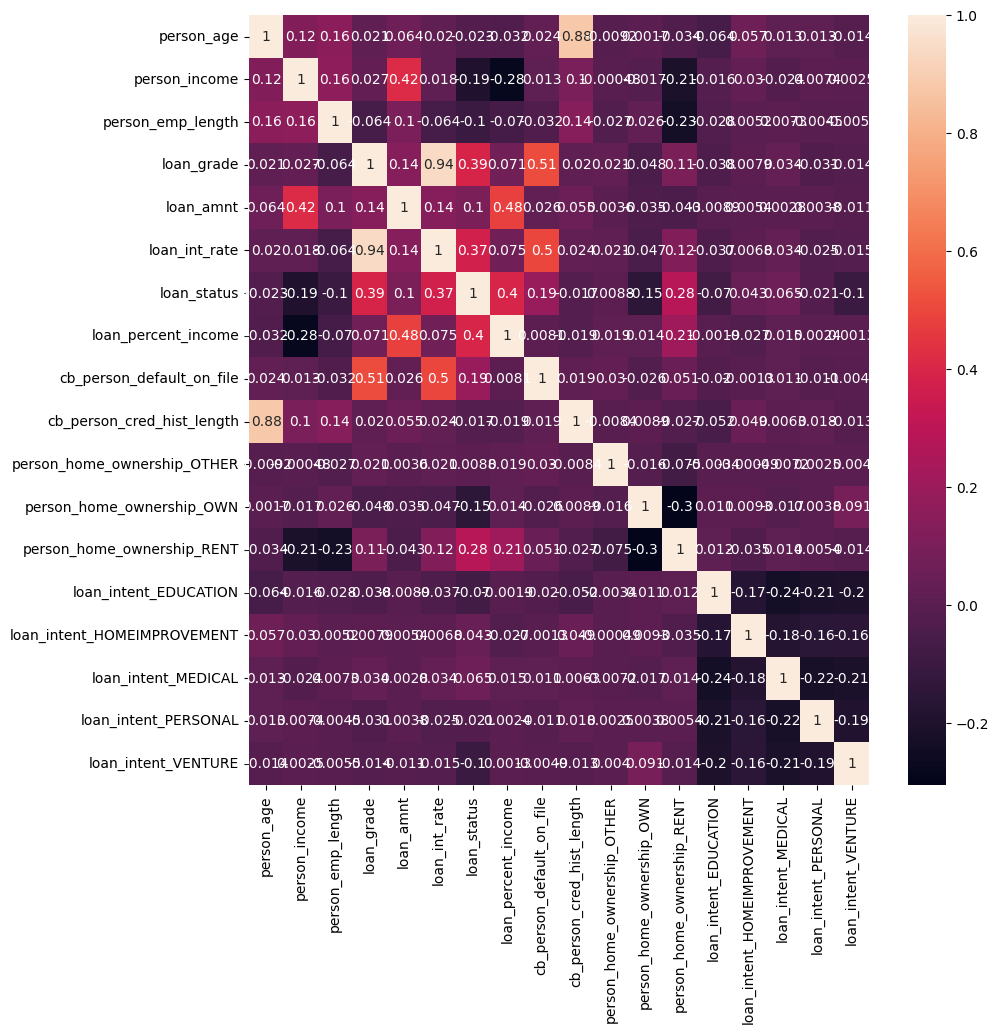

In [35]:
# check the correlation between the features
correlation_matrix = data_balanced.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(correlation_matrix, annot = True)
plt.show()

## Feature Engineering & Selection
Transformations and selecting orthogonal and strong features.

In [27]:
# more coming soon

Let's now try more architectures: decision tree, random forest, SVM, Naive Bayes, k-nearest neighbors, MLP. We will keep the updated data with the more balanced classes.

## Model: Decision Tree

In [ ]:
# more coming soon

## Model: Random Forest

In [ ]:
# more coming soon

## Model: Support Vector Machine (SVM)

In [ ]:
# more coming soon

## Model: Naive Bayes

In [ ]:
# more coming soon

## Model: k-nearest Neighbors

In [ ]:
# more coming soon

## Model: Neural Network, Multilayer Perceptron (MLP)

In [ ]:
# more coming soon